In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from splitkci import dependence_measures
from splitkci import pval_computations
from splitkci import cond_mean_estimation as cme
import scipy
import seaborn as sns

def get_error_mean_std(data, ground_truth, pval):
    if ground_truth == 'H0':
        data = 1 - (data >= pval).float()
    else:
        data = (data >= pval).float()

    mean = data.mean(dim=(-2, -1))
    std = data.std(dim=(-2, -1))
    return mean, std

In [2]:
plt.rcParams["svg.fonttype"] = 'none'

In [3]:
import warnings
warnings.filterwarnings('ignore')#action='once')#'ignore')

In [4]:
results_location = os.path.join(os.environ['SCRATCH'], 'splitkci_testing_results/ratinabox')
names = {'kci': 'KCI', 'kci_asplit': 'SplitKCI (A only)', 'circe': 'CIRCE', 'gcm': 'GCM', 'rbpt2_ub': 'RBPT2\'',
            'rbpt2': 'RBPT2', 'kci_absplit': 'SplitKCI', 'circe_bsplit': 'SplitCIRCE'}
colors = {'kci': '#0072B2', 'kci_asplit': '#009E73',
          'circe': '#821651', 'gcm': '#E69F00', 
          'rbpt2_ub': '#D55E00', 'rbpt2': '#000000', 'kci_absplit': '#000000',
          'circe_bsplit': '#808080'}


In [5]:
# your folder with results. Everything will be saved in './figs'
folder = '/network/scratch/r/roman.pogodin/splitkci_testing_results/'
task = 'randn'

In [7]:
def plot_pvals_standard(measures_list, figure_path, 
                        task='ratinabox', dim=100, kernels='all',
                        h0_max=1.05, h0_min=-0.05,
                        log_scale=False, budget=0, min_n=200):

    points_list = torch.linspace(min_n, 1000, (1000 - min_n) // 100 + 1).int()
    ticks = [str(i.item()) for i in points_list]

    fig, axes = plt.subplots(ncols=1, figsize=(5, 3), sharex=True)

    pval = 0.05
    xzy = 'joint'
    ground_truth = 'H0'
    axes.set_xlabel(r'$N$')
    axes.set_xticks(points_list, ticks)

    for measure in measures_list:
        ##################
        # loading data
        data = torch.zeros(len(points_list), 100, 1)
        if '_gamma' == measure[-6:]:
            gamma_idx = '_gamma'
            measure = measure[:-6]
            measure_ls = '--'
        else:
            gamma_idx = ''
            measure_ls = '-'
        suff = measure.split('__')[1]
        base_measure = measure.split('__')[0]

        for idx, n_points in enumerate(points_list):
            xzy_actual = xzy
            kernels_actual = kernels

            file = f'{task}_0.05_both_0.05_{base_measure}_{kernels_actual}_{xzy_actual}_{budget}_{min_n}_{ground_truth}{gamma_idx}seeds0_100_d{dim}_abc{n_points}_aux0_{suff}.pt'
            data[idx] = torch.load(os.path.join(folder, task, file))

        mean, std = get_error_mean_std(data, ground_truth, pval)
        ##################

        sqn_x = np.sqrt(data.shape[1])
        label = names[base_measure]
        color = colors[base_measure]

        axes.plot(points_list, mean, label=label, color=color, linestyle=measure_ls)
        axes.fill_between(points_list, 
                          mean - std / sqn_x, 
                          mean + std / sqn_x, alpha=0.05, color=color)

    

    axes.axhline(pval, color='r', linestyle='--', label=fr'$\alpha$={pval}')
    axes.set_ylabel(fr'Type I error')
    
    axes.set_ylim(h0_min, h0_max)
    
    if log_scale:
        axes.set_yscale('log')
        

    axes.legend(frameon=False, ncol=1)
    plt.tight_layout()
    plt.savefig(figure_path, transparent=True)
    plt.show()

# Main text

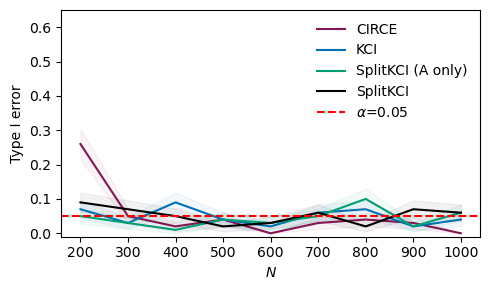

In [91]:
measures_list = [
                'circe__ttsplit_100',
                'kci__ttsplit_100',
                'kci_asplit__ttsplit_100',
                'kci_absplit__ttsplit_100',
                ]
    
plot_pvals_standard(measures_list, 'figs/app_wild_comparison.svg', 
                    task='randn', dim=2, kernels='gaussian',
                    h0_max=0.65, h0_min=-0.01,
                    log_scale=False, budget=0, min_n=200)

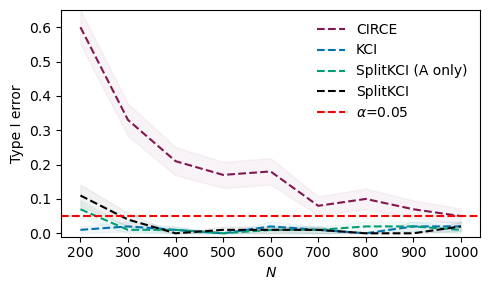

In [90]:
measures_list = [
                'circe__ttsplit_100_gamma',
                'kci__ttsplit_100_gamma',
                'kci_asplit__ttsplit_100_gamma',
                'kci_absplit__ttsplit_100_gamma',
                ]
    
plot_pvals_standard(measures_list, 'figs/app_gamma_comparison.svg', 
                    task='randn', dim=2, kernels='gaussian',
                    h0_max=0.65, h0_min=-0.01,
                    log_scale=False, budget=0, min_n=200)

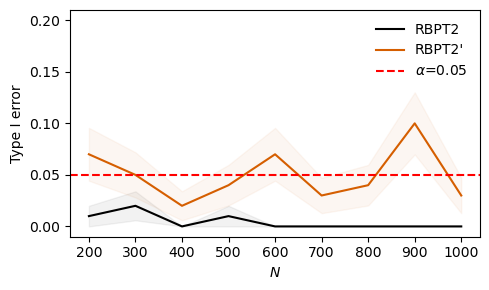

In [8]:
measures_list = [
                'rbpt2__ttsplit_100',
                'rbpt2_ub__ttsplit_100',
                ]
    
plot_pvals_standard(measures_list, 'figs/app_rbpt_comparison.svg', 
                    task='randn', dim=2, kernels='gaussian',
                    h0_max=0.21, h0_min=-0.01,
                    log_scale=False, budget=0, min_n=200)